In [22]:
import model_loader
import pipeline
from PIL import Image
from pathlib import Path
from transformers import CLIPTokenizer
import torch

In [23]:
if torch.backends.mps.is_available():
    # Mac
    device = "mps"
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = "cpu"

print(f'Using device: {device}')

DEVICE = device

Using device: mps


100%|██████████| 50/50 [02:09<00:00,  2.60s/it]


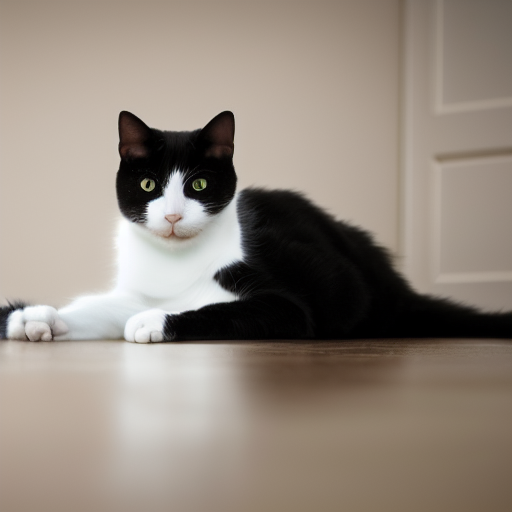

In [24]:
tokenizer = CLIPTokenizer("../data/vocab.json", merges_file="../data/merges.txt")
model_file = "../data/v1-5-pruned-emaonly.ckpt"
models = model_loader.preload_models_from_standard_weights(model_file, DEVICE)

## TEXT TO IMAGE

# prompt = "A dog with sunglasses, wearing comfy hat, looking at camera, highly detailed, ultra sharp, cinematic, 100mm lens, 8k resolution."
prompt = "A cat stretching on the floor, highly detailed, ultra sharp, cinematic, 100mm lens, 8k resolution."
uncond_prompt = ""  # Also known as negative prompt
do_cfg = True
cfg_scale = 8  # min: 1, max: 14

## IMAGE TO IMAGE

input_image = None
# Comment to disable image to image
image_path = "../images/dog.jpg"
# input_image = Image.open(image_path)
# Higher values means more noise will be added to the input image, so the result will further from the input image.
# Lower values means less noise is added to the input image, so output will be closer to the input image.
strength = 0.9

## SAMPLER

sampler = "ddpm"
num_inference_steps = 50
seed = 42

output_image = pipeline.generate(
    prompt=prompt,
    uncond_prompt=uncond_prompt,
    input_image=input_image,
    strength=strength,
    do_cfg=do_cfg,
    cfg_scale=cfg_scale,
    sampler_name=sampler,
    n_inference_steps=num_inference_steps,
    seed=seed,
    models=models,
    device=DEVICE,
    idle_device="cpu",
    tokenizer=tokenizer,
)

# Combine the input image and the output image into a single image.
Image.fromarray(output_image)

In [26]:
models = model_loader.preload_models_from_standard_weights(model_file, DEVICE)


In [27]:
print(models.keys())


dict_keys(['clip', 'encoder', 'decoder', 'diffusion'])


In [32]:
diffusion = models['diffusion']
_clip = models["clip"]
_encoder = models["encoder"]
_decoder = models["decoder"]
print(diffusion)

Diffusion(
  (time_embedding): TimeEmbedding(
    (linear_1): Linear(in_features=320, out_features=1280, bias=True)
    (linear_2): Linear(in_features=1280, out_features=1280, bias=True)
  )
  (unet): UNET(
    (encoders): ModuleList(
      (0): SwitchSequential(
        (0): Conv2d(4, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (1-2): 2 x SwitchSequential(
        (0): UNET_ResidualBlock(
          (groupnorm_feature): GroupNorm(32, 320, eps=1e-05, affine=True)
          (conv_feature): Conv2d(320, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (linear_time): Linear(in_features=1280, out_features=320, bias=True)
          (groupnorm_merged): GroupNorm(32, 320, eps=1e-05, affine=True)
          (conv_merged): Conv2d(320, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (residual_layer): Identity()
        )
        (1): UNET_AttentionBlock(
          (groupnorm): GroupNorm(32, 320, eps=1e-06, affine=True)
          (conv_inp

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total trainable parameters in UNet: {count_parameters(diffusion):,}")
print(f"Total trainable parameters in Encoder: {count_parameters(_encoder):,}")
print(f"Total trainable parameters in Decoder: {count_parameters(_decoder):,}")
print(f"Total trainable parameters in CLIP: {count_parameters(_clip):,}")

Total trainable parameters in Diffusion: 859,520,964
Total trainable parameters in Encoder: 34,163,664
Total trainable parameters in Decoder: 49,490,199
Total trainable parameters in CLIP: 123,060,480
